### 04 — Baseline Market-Making Strategy on BTC Perpetuals

This notebook implements the **fixed baseline market-making (MM) strategy** on top of your BTC price simulator and studies its equity and inventory behaviour over a 14-day horizon.

---

#### 4.1 Step 1 — Fix Parameters and Risk Limits

In this step you collect all MM and risk parameters in one place.

- Choose and record:
  - Half-spread parameter: $s_0$
  - Base order size: $q_0$
  - Inventory skew strength: $k_s$
  - Max inventory: $I_{\max}$
  - Minimum equity: $\Pi_{\min}$
- Fix the time grid for the MM simulation:
  - Use 5-minute steps, consistent with your BTC simulator.
  - Set the horizon to **14 calendar days**:
    $$
    T_{\text{days}} = 14, \quad
    N = T_{\text{days}} \times 24 \times 12
    $$
- Define the number of Monte Carlo paths, for example:
  - $M = 100$–$500$ paths for initial testing.
  - You can later increase $M$ for more stable statistics.

---



Simulation setup: 14 days, 4032 time steps, 50 paths
Starting market maker simulation...
Simulation completed! Risk breach paths: 0


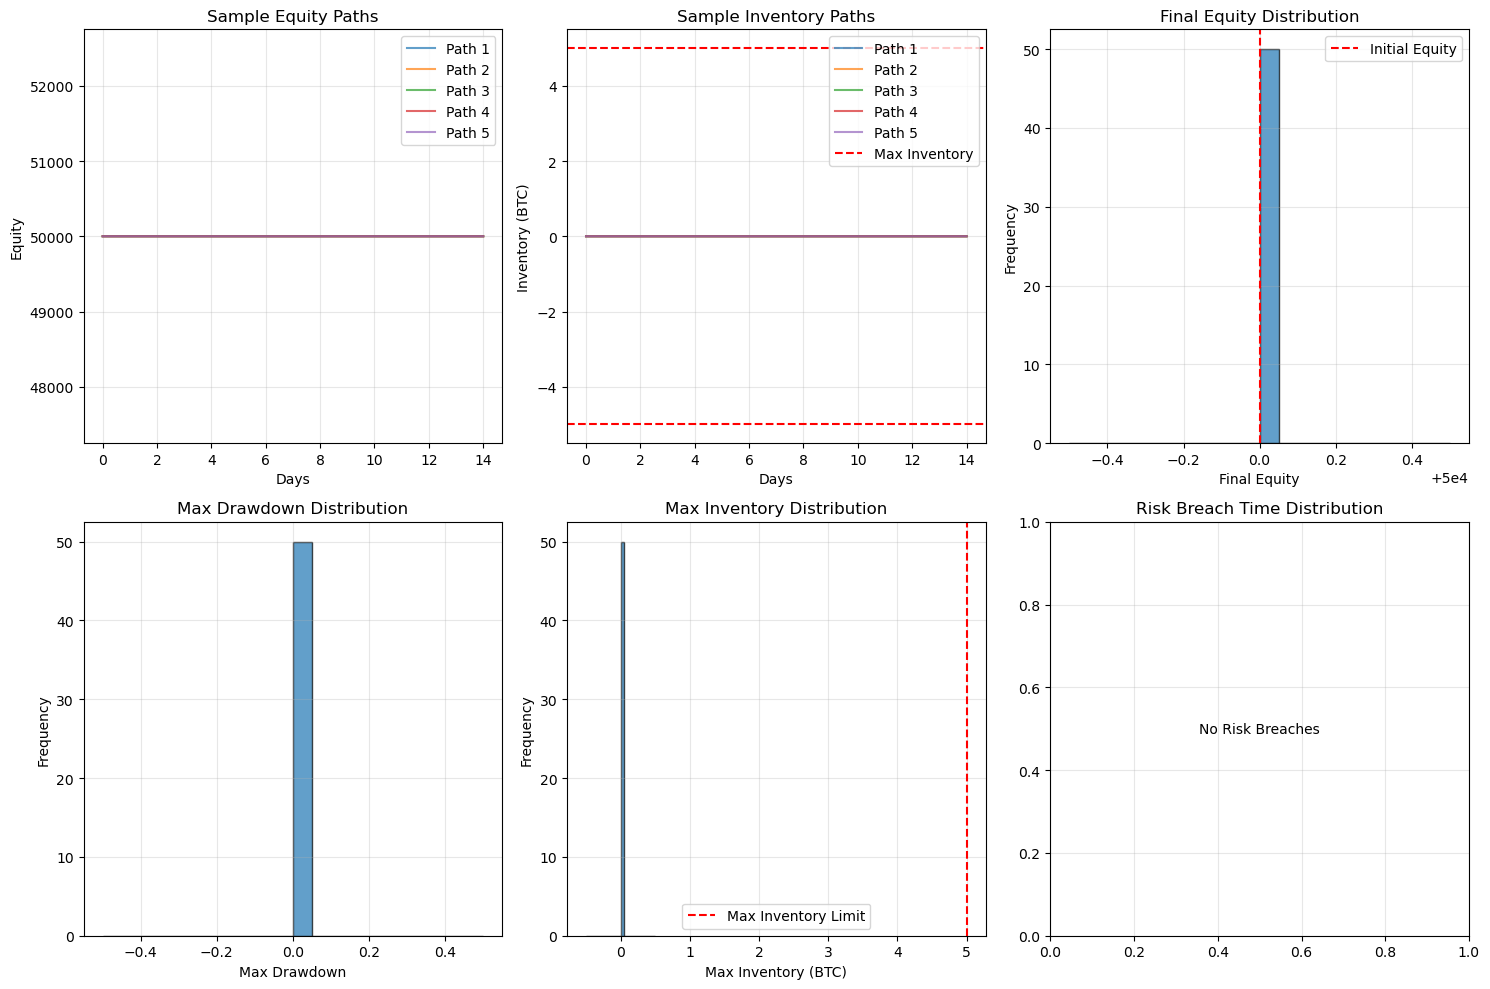


=== Market Maker Strategy Statistical Summary ===
Final Equity Statistics:
  Mean: 50000.00
  Std: 0.00
  Min: 50000.00
  Max: 50000.00

Inventory Statistics:
  Average Max Inventory: 0.00 BTC
  Risk Breach Paths: 0/50

Drawdown Statistics:
  Average Max Drawdown: 0.00%
  Max Drawdown: 0.00%

Market Maker Baseline Strategy Implementation Completed!


In [4]:
# Declare parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import torch

def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

set_seeds(42)

# 4.1 Parameter Settings
MM_PARAMS = {
    's0': 0.001,           # Half-spread parameter
    'q0': 0.1,             # Base order size (BTC)
    'ks': 0.0005,          # Inventory skew strength
    'I_max': 5.0,          # Max inventory (BTC)
    'Pi_min': 45000,       # Minimum equity
    'Pi_init': 50000,      # Initial equity
    'T_days': 14,          # Simulation days
    'M_paths': 50          # Monte Carlo paths
}

# Time grid settings (5-minute frequency)
N_steps = MM_PARAMS['T_days'] * 24 * 12  # 14 days * 24 hours * 12 five-minutes
print(f"Simulation setup: {MM_PARAMS['T_days']} days, {N_steps} time steps, {MM_PARAMS['M_paths']} paths")

# 4.2 State Variables and Market Maker Class
class MarketMaker:
    def __init__(self, params):
        self.params = params
        self.reset()
    
    def reset(self):
        """Reset state"""
        self.S = 0.0          # Spot price
        self.I = 0.0          # Inventory
        self.cash = self.params['Pi_init']  # Cash
        self.equity = self.params['Pi_init']  # Equity
        
    @property
    def phi(self):
        """Normalized inventory"""
        return self.I / self.params['I_max']
    
    def compute_quotes(self):
        """Compute bid/ask quotes"""
        s0, ks = self.params['s0'], self.params['ks']
        
        # Base quotes
        P_bid = self.S * (1 - s0 - ks * self.phi)
        P_ask = self.S * (1 + s0 + ks * self.phi)
        
        # Size control
        q = self.params['q0'] * max(0, 1 - abs(self.phi))
        
        # Hard kill-switch
        if abs(self.I) >= self.params['I_max']:
            if self.I > 0:  # Net long, only sell
                return P_bid, 0, P_ask, q
            else:  # Net short, only buy
                return P_bid, q, P_ask, 0
        else:
            return P_bid, q, P_ask, q
    
    def update_fills(self, P_bid, q_bid, P_ask, q_ask, H, L, S_next):
        """Update fill logic"""
        # Check fill conditions
        bid_filled = L <= P_bid <= H and q_bid > 0
        ask_filled = L <= P_ask <= H and q_ask > 0
        
        # Update inventory and cash
        if bid_filled:
            self.I += q_bid
            self.cash -= q_bid * P_bid
        
        if ask_filled:
            self.I -= q_ask
            self.cash += q_ask * P_ask
        
        # Update price and equity
        self.S = S_next
        self.equity = self.cash + self.I * self.S
        
        return bid_filled, ask_filled
    
    def risk_breach(self):
        """Check risk breach"""
        return (abs(self.I) > self.params['I_max'] or 
                self.equity < self.params['Pi_min'])

# 4.3 BTC Price Simulator (Simplified)
def simulate_btc_paths(n_paths, n_steps, initial_price=50000):
    """Simulate BTC price paths"""
    paths = []
    for _ in range(n_paths):
        prices = [initial_price]
        for i in range(1, n_steps):
            # Geometric Brownian Motion
            dt = 1/(365*24*12)  # 5-minute time step
            mu = 0.0001  # Daily drift
            sigma = 0.02  # Daily volatility
            
            drift = (mu - 0.5 * sigma**2) * dt
            shock = sigma * np.sqrt(dt) * np.random.normal()
            price = prices[-1] * np.exp(drift + shock)
            prices.append(price)
        
        # Generate OHLC data (simplified: based on close prices)
        ohlc = generate_ohlc_from_close(prices)
        paths.append(ohlc)
    
    return paths

def generate_ohlc_from_close(close_prices):
    """Generate OHLC data from close prices"""
    n = len(close_prices)
    open_prices = [close_prices[0]] + close_prices[:-1]
    high_prices = [max(o, c) + abs(o-c)*0.1 for o, c in zip(open_prices, close_prices)]
    low_prices = [min(o, c) - abs(o-c)*0.1 for o, c in zip(open_prices, close_prices)]
    
    return {
        'open': open_prices,
        'high': high_prices,
        'low': low_prices,
        'close': close_prices
    }

# 4.5 Monte Carlo Simulation
def run_mm_simulation():
    """Run market maker Monte Carlo simulation"""
    print("Starting market maker simulation...")
    
    # Generate BTC price paths
    btc_paths = simulate_btc_paths(
        MM_PARAMS['M_paths'], 
        N_steps + 1,  # +1 to include initial point
        initial_price=50000
    )
    
    # Store results
    results = {
        'equity_paths': [],
        'inventory_paths': [],
        'risk_breaches': [],
        'final_equity': [],
        'max_inventory': []
    }
    
    for m in range(MM_PARAMS['M_paths']):
        mm = MarketMaker(MM_PARAMS)
        ohlc = btc_paths[m]
        
        # Initialize
        mm.S = ohlc['close'][0]
        equity_path = [mm.equity]
        inventory_path = [mm.I]
        breach_time = None
        
        # Time step loop
        for n in range(N_steps):
            # Compute quotes
            P_bid, q_bid, P_ask, q_ask = mm.compute_quotes()
            
            # Get next candle OHLC
            H, L = ohlc['high'][n+1], ohlc['low'][n+1]
            S_next = ohlc['close'][n+1]
            
            # Update fills
            mm.update_fills(P_bid, q_bid, P_ask, q_ask, H, L, S_next)
            
            # Check risk breach
            if breach_time is None and mm.risk_breach():
                breach_time = n
            
            # Store state
            equity_path.append(mm.equity)
            inventory_path.append(mm.I)
        
        # Store path results
        results['equity_paths'].append(equity_path)
        results['inventory_paths'].append(inventory_path)
        results['risk_breaches'].append(breach_time)
        results['final_equity'].append(mm.equity)
        results['max_inventory'].append(max(abs(i) for i in inventory_path))
    
    print(f"Simulation completed! Risk breach paths: {sum(1 for x in results['risk_breaches'] if x is not None)}")
    return results

# Run simulation
results = run_mm_simulation()

# 4.6 Diagnostic Analysis
def plot_diagnostics(results):
    """Plot diagnostic charts"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Sample Equity Paths
    sample_paths = min(5, MM_PARAMS['M_paths'])
    for i in range(sample_paths):
        equity = results['equity_paths'][i]
        days = np.arange(len(equity)) / (24 * 12)  # Convert to days
        axes[0,0].plot(days, equity, alpha=0.7, label=f'Path {i+1}')
    
    axes[0,0].set_xlabel('Days')
    axes[0,0].set_ylabel('Equity')
    axes[0,0].set_title('Sample Equity Paths')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].legend()
    
    # 2. Sample Inventory Paths
    for i in range(sample_paths):
        inventory = results['inventory_paths'][i]
        days = np.arange(len(inventory)) / (24 * 12)
        axes[0,1].plot(days, inventory, alpha=0.7, label=f'Path {i+1}')
    
    axes[0,1].axhline(y=MM_PARAMS['I_max'], color='r', linestyle='--', label='Max Inventory')
    axes[0,1].axhline(y=-MM_PARAMS['I_max'], color='r', linestyle='--')
    axes[0,1].set_xlabel('Days')
    axes[0,1].set_ylabel('Inventory (BTC)')
    axes[0,1].set_title('Sample Inventory Paths')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].legend()
    
    # 3. Final Equity Distribution
    axes[0,2].hist(results['final_equity'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,2].axvline(x=MM_PARAMS['Pi_init'], color='r', linestyle='--', label='Initial Equity')
    axes[0,2].set_xlabel('Final Equity')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Final Equity Distribution')
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].legend()
    
    # 4. Max Drawdown Distribution
    drawdowns = []
    for equity_path in results['equity_paths']:
        peak = np.maximum.accumulate(equity_path)
        drawdown = (peak - equity_path) / peak
        drawdowns.append(np.max(drawdown))
    
    axes[1,0].hist(drawdowns, bins=20, alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Max Drawdown')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Max Drawdown Distribution')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Max Inventory Distribution
    axes[1,1].hist(results['max_inventory'], bins=20, alpha=0.7, edgecolor='black')
    axes[1,1].axvline(x=MM_PARAMS['I_max'], color='r', linestyle='--', label='Max Inventory Limit')
    axes[1,1].set_xlabel('Max Inventory (BTC)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Max Inventory Distribution')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].legend()
    
    # 6. Risk Breach Times
    breach_times = [t for t in results['risk_breaches'] if t is not None]
    if breach_times:
        axes[1,2].hist(breach_times, bins=20, alpha=0.7, edgecolor='black')
        axes[1,2].set_xlabel('Breach Time Step')
        axes[1,2].set_ylabel('Frequency')
    else:
        axes[1,2].text(0.5, 0.5, 'No Risk Breaches', ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('Risk Breach Time Distribution')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Output statistical summary
    print("\n=== Market Maker Strategy Statistical Summary ===")
    print(f"Final Equity Statistics:")
    print(f"  Mean: {np.mean(results['final_equity']):.2f}")
    print(f"  Std: {np.std(results['final_equity']):.2f}")
    print(f"  Min: {np.min(results['final_equity']):.2f}")
    print(f"  Max: {np.max(results['final_equity']):.2f}")
    
    print(f"\nInventory Statistics:")
    print(f"  Average Max Inventory: {np.mean(results['max_inventory']):.2f} BTC")
    print(f"  Risk Breach Paths: {len(breach_times)}/{MM_PARAMS['M_paths']}")
    
    print(f"\nDrawdown Statistics:")
    print(f"  Average Max Drawdown: {np.mean(drawdowns):.2%}")
    print(f"  Max Drawdown: {np.max(drawdowns):.2%}")

# Plot diagnostic charts
plot_diagnostics(results)

print("\nMarket Maker Baseline Strategy Implementation Completed!")



#### 4.2 Step 2 — Define State Variables and Initial Conditions

You now specify the MM state and how it is initialised on each path.

- State at time step $n$:
  - Spot price: $S_n$
  - Inventory: $I_n$
  - Cash: $\text{Cash}_n$
  - Equity:
    $$
    \Pi_n = \text{Cash}_n + I_n S_n
    $$
- For each Monte Carlo path:
  - Obtain a simulated BTC price path from your simulator (Section 02), including:
    - Mid prices $S_0, S_1, \dots, S_N$
    - Candle highs and lows $H_1, \dots, H_N$ and $L_1, \dots, L_N$ (or construct OHLC from the mid-price path as specified in your simulator notebook).
  - Set initial conditions:
    - $I_0 = 0$ (flat inventory)
    - $\text{Cash}_0 = \Pi_{\text{init}}$ for some chosen initial equity.
    - $\Pi_0 = \Pi_{\text{init}}$.
- Pre-allocate arrays (or lists) to store, for each path:
  - $I_n$, $\text{Cash}_n$, $\Pi_n$ over $n = 0, \dots, N$.

---



#### 4.3 Step 3 — Implement the Quoting and Size Rules

You now implement the deterministic mapping from state $(S_n, I_n)$ to quotes and order size.

- Compute **normalised inventory**:
  $$
  \phi_n = \frac{I_n}{I_{\max}}.
  $$
- Define the **skewed bid/ask quotes**:
  $$
  P_n^{\text{bid}} = S_n \big( 1 - s_0 - k_s \phi_n \big),
  $$
  $$
  P_n^{\text{ask}} = S_n \big( 1 + s_0 + k_s \phi_n \big).
  $$
- Define the **size control** rule:
  $$
  q_n = q_0 \cdot \max\big(0,\; 1 - |\phi_n|\big).
  $$
- Implement the **hard kill-switch** on quotes:
  - If $|I_n| < I_{\max}$:
    - Quote **both** bid and ask with size $q_n$.
  - If $|I_n| \ge I_{\max}$:
    - Only quote in the direction that **reduces** $|I_n|$:
      - If $I_n > 0$ (net long): only quote **ask** (to sell).
      - If $I_n < 0$ (net short): only quote **bid** (to buy).
    - On the non-reducing side, you can set the size to zero (no order).

---

#### 4.4 Step 4 — Fill Logic and State Update (One Step)

You now specify how orders are filled within one 5-minute step and how the state is updated.

For each step $n \to n+1$ and for each path:

1. **Given at time $t_n$:**
   - Current state: $S_n$, $I_n$, $\text{Cash}_n$.
   - Quotes and size from Step 3:
     - $P_n^{\text{bid}}$, $P_n^{\text{ask}}$, $q_n$.
2. **Check candle extremes** for the $(n+1)$-th 5-minute candle:
   - Use $H_{n+1}$ (high) and $L_{n+1}$ (low) from your BTC path.
3. **Apply the full-fill rule**:
   - Bid fill if
     $$
     L_{n+1} \le P_n^{\text{bid}} \le H_{n+1}.
     $$
   - Ask fill if
     $$
     L_{n+1} \le P_n^{\text{ask}} \le H_{n+1}.
     $$
   - If the condition is satisfied, the order is **fully filled** (no partial fills).
   - It is allowed that both sides fill in the same candle if both conditions hold.
4. **Update inventory and cash**:
   - If the bid is filled (buy $q_n$ units at $P_n^{\text{bid}}$):
     $$
     I_{n}^{\text{new}} = I_n + q_n,
     \quad
     \text{Cash}_{n}^{\text{new}} = \text{Cash}_n - q_n P_n^{\text{bid}}.
     $$
   - If the ask is filled (sell $q_n$ units at $P_n^{\text{ask}}$):
     $$
     I_{n}^{\text{new}} = I_{n}^{\text{new}} - q_n,
     \quad
     \text{Cash}_{n}^{\text{new}} = \text{Cash}_{n}^{\text{new}} + q_n P_n^{\text{ask}}.
     $$
   - If a side does **not** fill, leave $I$ and Cash unchanged for that side.
   - After processing both sides, set:
     - $I_{n+1} = I_{n}^{\text{new}}$
     - $\text{Cash}_{n+1} = \text{Cash}_{n}^{\text{new}}$.
5. **Move spot and recompute equity**:
   - Set $S_{n+1}$ from the BTC simulator.
   - Compute equity:
     $$
     \Pi_{n+1} = \text{Cash}_{n+1} + I_{n+1} S_{n+1}.
     $$
6. **Check risk limits** (for monitoring or early stopping):
   - Flag a **risk breach** if
     $$
     |I_{n+1}| > I_{\max}
     \quad \text{or} \quad
     \Pi_{n+1} < \Pi_{\min}.
     $$
   - Decide whether you:
     - Stop the path when a breach occurs (liquidation scenario), or
     - Continue the simulation but record the breach time.

This completes one MM step. You will loop this logic over $n = 0,\dots,N-1$ for each path.

---

#### 4.5 Step 5 — Monte Carlo Simulation of the Baseline MM Strategy

You now combine Steps 1–4 into a full Monte Carlo experiment.

- For each Monte Carlo path $m = 1,\dots,M$:
  1. Simulate a BTC path $(S_n^{(m)}, H_n^{(m)}, L_n^{(m)})_{n=0,\dots,N}$ using your BTC simulator.
  2. Initialise $I_0^{(m)}$, $\text{Cash}_0^{(m)}$, $\Pi_0^{(m)}$ as in Step 2.
  3. For $n = 0,\dots,N-1$:
     - Compute quotes and order size using the rules in Step 3.
     - Apply the fill and state update rules from Step 4.
     - Store $I_{n+1}^{(m)}$, $\text{Cash}_{n+1}^{(m)}$, $\Pi_{n+1}^{(m)}$.
- At the end of the simulation:
  - You have, for each path, full time series of:
    - Inventory $I_n^{(m)}$
    - Equity $\Pi_n^{(m)}$
    - (Optionally) mid-price $S_n^{(m)}$ and any risk-breach flags.

---

#### 4.6 Step 6 — Basic Diagnostics: Equity and Inventory Behaviour

Finally, analyse the behaviour of the baseline MM strategy.

- Plot **sample paths**:
  - Select a small number of paths (e.g. 5–10) and plot:
    - Equity $\Pi_n^{(m)}$ over time (in 5-minute steps or in days).
    - Inventory $I_n^{(m)}$ over time.
  - Visually inspect:
    - How often inventory hits the bounds $\pm I_{\max}$.
    - How volatile the equity is over 14 days.
- Summarise **distributional statistics**:
  - Histogram of final equity $\Pi_N^{(m)}$ across all paths.
  - Histogram of max drawdown or min equity over each path.
  - Histogram of max inventory $ \max_n |I_n^{(m)}|$ over each path.
- Comment on:
  - How aggressive the baseline strategy is in building inventory.
  - How often it approaches the risk limits.
  - Whether the 14-day PnL distribution appears “reasonable” given the BTC volatility from your simulator.



